In [1]:
## This Notebook contains:

## a step-by-step explanation of statsmodel GLM fit and evaluation --->

## EDA for data understanding and Data prep
## Class balance check and oversampling
## Statsmodels GLM used to observe significant features and model metrics
## Stepwise Backward Propagation done to drop insignificant features
## Model predictions are updated with optimal threshold calculated from the ROC-curve
## Final set of features used to train and save sklearn LogReg final model

## Importing Libraries

In [2]:
import pandas as pd
import numpy as np
import os
import glob
import sys
import datetime 
import pickle

#Importing Data visulaisation Libraries
import matplotlib.pyplot as plt
import seaborn as sns

#Importing Necessary ML Libraries
import statsmodels.api as sm
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV 

#For Dealing with Imbalanced Datasets
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from collections import Counter

# Other Libraries
import time

## Importing Data 

In [3]:
data = pd.read_csv("Customer_Churn.csv")
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [4]:
#Displaying no. of records and columns
data.shape

(10000, 14)

In [5]:
#Details of dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             10000 non-null int64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


- There are 10000 records with 14 columns.
- Apart from three columns which are categorical, rest are continuous (numerical).
- As evident from the non-null count, no values are missing.
- Target variable is "Exited" which we'll predict.

## Data Pre-Processing & EDA

In [6]:
#Dropping insignificant columns
drop_cols = ["RowNumber","CustomerId","Surname"]
data.drop(drop_cols, axis=1, inplace=True)

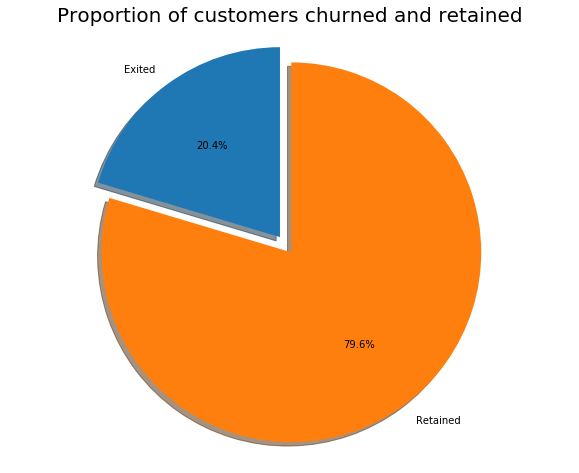

In [7]:
#Status of customer churn
sizes = [data.Exited[data['Exited']==1].count(), data.Exited[data['Exited']==0].count()]
plt.subplots(figsize=(10, 8))
plt.pie(sizes, explode=(0, 0.1), labels=['Exited', 'Retained'], autopct='%1.1f%%', shadow=True, startangle=90)
plt.axis('equal')
plt.title("Proportion of customers churned and retained", size = 20)
plt.show()

- 20% customers have exited from the bank and ~80% retained.
- The classes are highly imbalanced, which will be dealt with later.

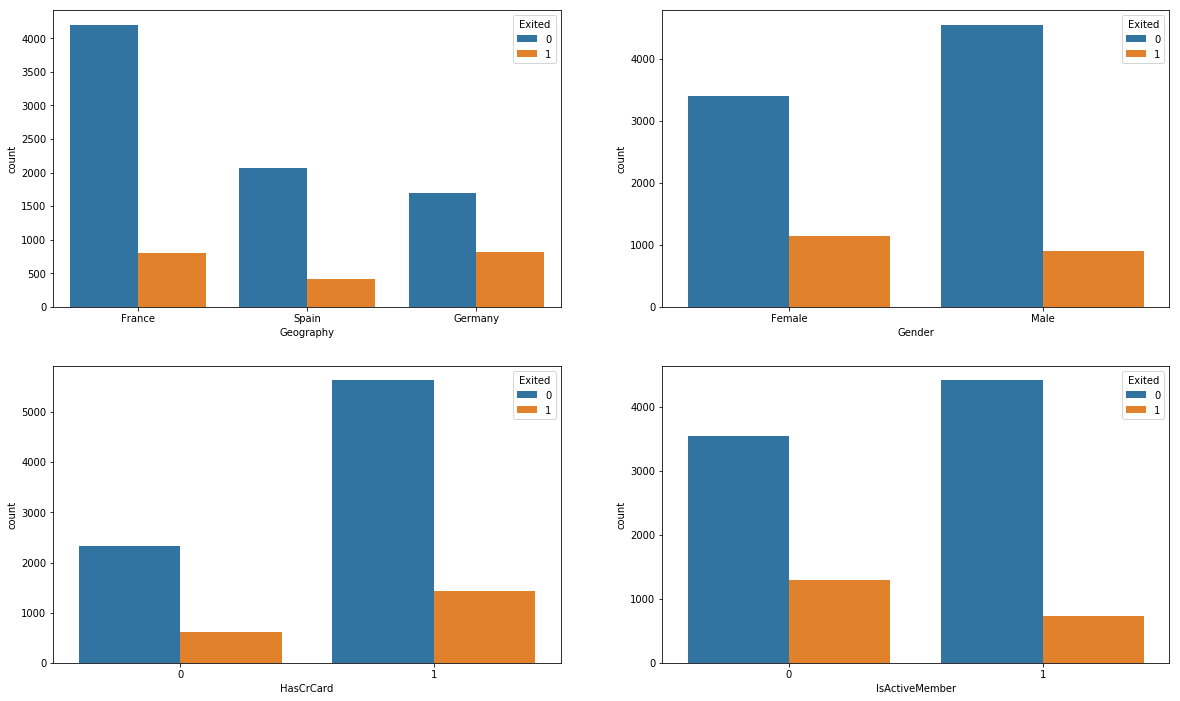

In [8]:
#Reviewing the relation of target variable with categorical variables
fig, axarr = plt.subplots(2, 2, figsize=(20, 12))
sns.countplot(x='Geography', hue='Exited', data=data, ax=axarr[0][0])
sns.countplot(x='Gender', hue='Exited', data=data, ax=axarr[0][1])
sns.countplot(x='HasCrCard', hue='Exited', data=data, ax=axarr[1][0])
sns.countplot(x='IsActiveMember', hue='Exited', data=data, ax=axarr[1][1])

- Majority of the data is from France. However, the proportion of churned customers is inversely related to the population of customers alluding to the bank possibly having a problem (maybe not enough customer service resources allocated) in the areas where it has fewer clients.

- The proportion of female customers churning is also greater than that of male customers.

- Interestingly, majority of the customers that churned are those with credit cards. Given that majority of the customers have credit cards could prove this to be just a coincidence.

- Unsurprisingly, the inactive members have a greater churn. It's concerning that the overall proportion of inactive mebers is quite high, suggesting that the bank may need a program implemented to turn this group to active customers as this will definitely have a positive impact on the customer churn.

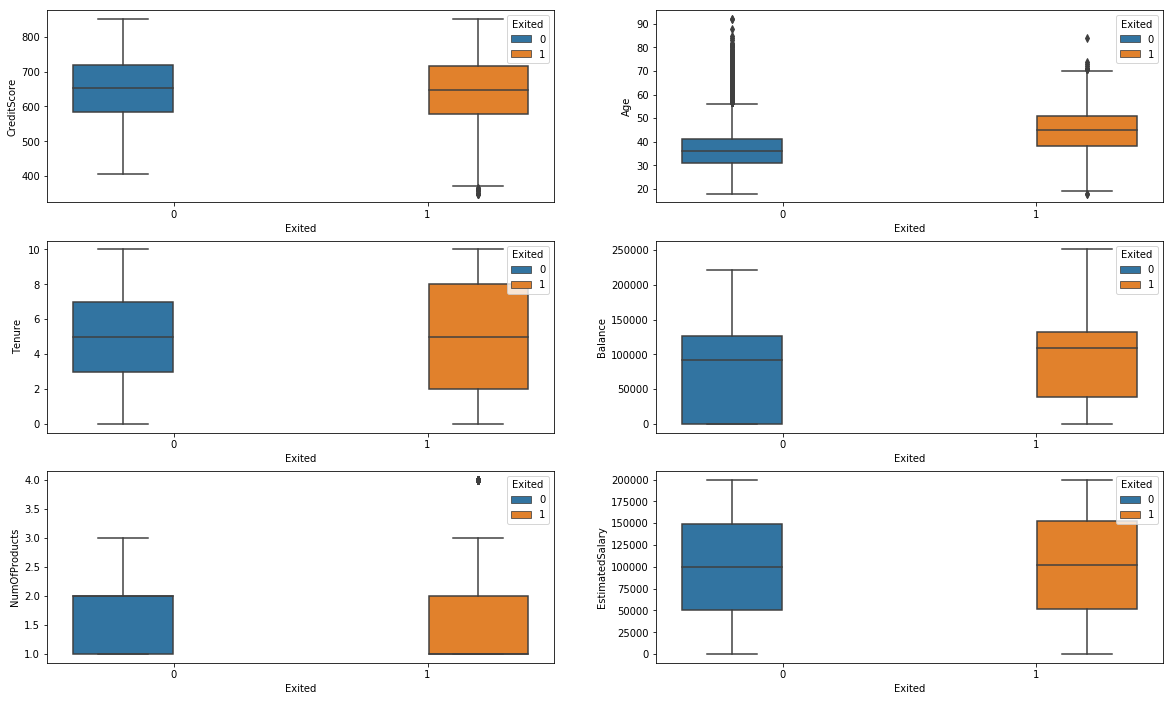

In [9]:
#Relations based on the continuous data attributes
fig, axarr = plt.subplots(3, 2, figsize=(20, 12))
sns.boxplot(y='CreditScore', x='Exited', hue='Exited', data=data, ax=axarr[0][0])
sns.boxplot(y='Age', x='Exited', hue='Exited', data=data, ax=axarr[0][1])
sns.boxplot(y='Tenure', x='Exited', hue='Exited', data=data, ax=axarr[1][0])
sns.boxplot(y='Balance', x='Exited', hue='Exited', data=data, ax=axarr[1][1])
sns.boxplot(y='NumOfProducts', x='Exited', hue='Exited', data=data, ax=axarr[2][0])
sns.boxplot(y='EstimatedSalary', x='Exited', hue='Exited', data=data, ax=axarr[2][1])

- There is no significant difference in the credit score distribution between retained and churned customers.

- The older customers are churning more than the younger ones implying a difference in service preference among the age categories. The bank may need to review their target market or review the strategy for retention between the different age groups.

- With regard to the tenure, the clients on either extreme end (spent little time with the bank or a lot of time with the bank) are more likely to churn compared to those that are of average tenure.

- Worryingly, the bank is losing customers with significant bank balances which is likely to hit their available capital for lending.

- Neither the product nor the salary has a significant effect on the likelihood to churn.

### Scaling of Features

Feature scaling of numerical columns that have a large range.

In [10]:
#Log scaling "Balance" & "EstimatedSalary" features, and dropping the same
data['Log_Balance'] = data['Balance'].apply(lambda x: np.log10(x+1))
data['Log_Est_Salary'] = data['EstimatedSalary'].apply(lambda x: np.log10(x+1))

In [11]:
data.drop(['Balance','EstimatedSalary'], axis=1, inplace=True)

### Encoding Categorical Variables

Creating dummy variables of all categorical features

In [12]:
data_new = pd.get_dummies(data=data, prefix=['Geography','Gender'], columns=['Geography','Gender'])

In [13]:
data_new.head()

,CreditScore,Age,Tenure,NumOfProducts,HasCrCard,IsActiveMember,Exited,Log_Balance,Log_Est_Salary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,619,42,2,1,1,1,1,0.000000,5.005823,1,0,0,1,0
1,608,41,1,1,0,1,0,4.923290,5.051321,0,0,1,1,0
2,502,42,8,3,1,0,1,5.203201,5.056648,1,0,0,1,0
3,699,39,1,2,0,0,0,0.000000,4.972331,1,0,0,1,0
4,850,43,2,1,1,1,0,5.098685,4.898095,0,0,1,1,0


In [14]:
#Separating the features and target variables
x = data_new.drop('Exited',axis=1)
y = data_new['Exited']

In [15]:
#Splitting into train & test sets 
x_train,x_test,y_train,y_test = train_test_split(x, y, test_size=0.2, random_state=36)

### Oversampling and Undersampling.

_**Oversampling and undersampling** in data analysis are techniques used to adjust the class distribution of a data set (i.e. the ratio between the different classes/categories represented)._

Why Sampling?
 - To Overcome the issue Class imbalance we do sampling either Under or Oversampling data. So that we can overcome the bias toward one class during the training of our MachineLearning Models.

**Note - We already observed that class imbalance exists from our exploratory analysis.**

**One approach to addressing imbalanced datasets is to oversample the minority class. The simplest approach involves duplicating examples in the minority class, although these examples don’t add any new information to the model. Instead, new examples can be synthesized from the existing examples. This is a type of data augmentation for the minority class and is referred to as the Synthetic Minority Oversampling Technique, or SMOTE for short.**

In [16]:
def oversample_using_smote(xtrain, ytrain):
    print("IN TRAINING SAMPLE:")
    print("Before OverSampling, counts of label '0': {}".format(sum(ytrain == 0))) 
    print("Before OverSampling, counts of label '1': {} \n".format(sum(ytrain == 1))) 
    sm = SMOTE(random_state=2)
    xtrain_sm, ytrain_sm = sm.fit_resample(xtrain, ytrain.ravel())
    
    print("After OverSampling, counts of label '0': {}".format(sum(ytrain_sm == 0))) 
    print("After OverSampling, counts of label '1': {}".format(sum(ytrain_sm == 1))) 

    return xtrain_sm, ytrain_sm

In [17]:
x_train_new, y_train_new = oversample_using_smote(x_train,y_train)

IN TRAINING SAMPLE:
Before OverSampling, counts of label '0': 6404
Before OverSampling, counts of label '1': 1596 

After OverSampling, counts of label '0': 6404
After OverSampling, counts of label '1': 6404


In [18]:
## retain feature names to observe in the model summary
x_train_new = pd.DataFrame(x_train_new, columns=x_train.columns)

### GLM

In [19]:
## we need to explicitly add the intercept as the statsmodels package doesn't include it
x_train_new = sm.add_constant(x_train_new)
x_test = sm.add_constant(x_test)

In [20]:
log_reg = sm.GLM(y_train_new, x_train_new, family=sm.families.Binomial())

In [21]:
log_results = log_reg.fit()
print(log_results.summary2())

                Results: Generalized linear model
Model:               GLM              AIC:            14365.7274  
Link Function:       logit            BIC:            -106680.6045
Dependent Variable:  y                Log-Likelihood: -7170.9     
Date:                2021-05-26 19:02 LL-Null:        -8877.8     
No. Observations:    12808            Deviance:       14342.      
Df Model:            11               Pearson chi2:   1.33e+04    
Df Residuals:        12796            Scale:          1.0000      
Method:              IRLS                                         
------------------------------------------------------------------
                   Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
------------------------------------------------------------------
const             -1.7506   0.1673 -10.4626 0.0000 -2.0785 -1.4226
CreditScore       -0.0005   0.0002  -2.6260 0.0086 -0.0010 -0.0001
Age                0.0823   0.0022  37.8899 0.0000  0.0781  0.0866
Tenure      

** the co-efficients can be interpreted as - for every unit change in 'x', the olog of the odds ratio of the success of 'y' (whether the customer will churn or not churn) changes 'beta' times. So - For every unit change in Age, the log of the odds ratio of Churn Likelihood increases by 0.0823 times. It is the opposite for, say, Tenure, which has a negative coefficient **

** Taking a significance level of 5%, we remove features whose p-value>0.05 as they are not significant in contributing to the prediction model **

** Performing Stepwise Backward Propagation to remove the insignificant features **

In [22]:
x_train_new = x_train_new.drop('Geography_Germany', axis=1)
x_test = x_test.drop('Geography_Germany', axis=1)

In [23]:
log_reg = sm.GLM(y_train_new, x_train_new, family=sm.families.Binomial())
log_results = log_reg.fit()
print(log_results.summary2())

                Results: Generalized linear model
Model:              GLM              AIC:            14365.7274  
Link Function:      logit            BIC:            -106680.6045
Dependent Variable: y                Log-Likelihood: -7170.9     
Date:               2021-05-26 19:03 LL-Null:        -8877.8     
No. Observations:   12808            Deviance:       14342.      
Df Model:           11               Pearson chi2:   1.33e+04    
Df Residuals:       12796            Scale:          1.0000      
Method:             IRLS                                         
-----------------------------------------------------------------
                  Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-----------------------------------------------------------------
const            -1.7401   0.2069  -8.4090 0.0000 -2.1457 -1.3345
CreditScore      -0.0005   0.0002  -2.6260 0.0086 -0.0010 -0.0001
Age               0.0823   0.0022  37.8899 0.0000  0.0781  0.0866
Tenure           -0.0228  

In [24]:
x_train_new = x_train_new.drop('HasCrCard', axis=1)
x_test = x_test.drop('HasCrCard', axis=1)

In [25]:
log_reg = sm.GLM(y_train_new, x_train_new, family=sm.families.Binomial())
log_results = log_reg.fit()
print(log_results.summary2())

                Results: Generalized linear model
Model:              GLM              AIC:            14364.9270  
Link Function:      logit            BIC:            -106688.8628
Dependent Variable: y                Log-Likelihood: -7171.5     
Date:               2021-05-26 19:03 LL-Null:        -8877.8     
No. Observations:   12808            Deviance:       14343.      
Df Model:           10               Pearson chi2:   1.33e+04    
Df Residuals:       12797            Scale:          1.0000      
Method:             IRLS                                         
-----------------------------------------------------------------
                  Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-----------------------------------------------------------------
const            -1.7681   0.2053  -8.6113 0.0000 -2.1705 -1.3657
CreditScore      -0.0005   0.0002  -2.6186 0.0088 -0.0010 -0.0001
Age               0.0824   0.0022  37.8956 0.0000  0.0781  0.0866
Tenure           -0.0229  

In [26]:
predictions = log_results.predict(x_test)
predictions[1:5]

5581    0.674021
3466    0.191057
4483    0.795386
5366    0.583169
dtype: float64

** The predicted values gives you the likelihood of the event, in this case - the likelihood of whether the person will churn or not. The first observation indicates that person has a 67% churn rate while the second person has a 19% churn rate **

In [27]:
threshold=0.5
predicted_classes = np.where(predictions>threshold, 1, 0)

** lets evaluate the model performance **

Evaluation metrics:

- **Accuracy score** - ratio of number of correct predictions to the total number of input samples

- **ROC-AUC** - ROC is a probability curve and AUC represents the degree or measure of separability; tells how much the model is capable of distinguishing between classes

- **Confusion matrix** - a kind of contingency table, with two dimensions ("actual" and "predicted"), and identical sets of "classes" in both dimensions (each combination of dimension and class is a variable in the contingency table)

- **Precision** - quantifies the number of positive class predictions that actually belong to the positive class

- **Recall** - quantifies the number of positive class predictions made out of all positive examples in the dataset

- **F1-score** - harmonic mean of precision and recall and a better measure than accuracy score

In [28]:
accuracy_score(y_test, predicted_classes)

0.708

In [29]:
confmat = confusion_matrix(y_test,predicted_classes)
conf = pd.DataFrame(confmat, index=['Actual 0','Actual 1'],columns=['Predicted 0','Predicted 1'])
conf

,Predicted 0,Predicted 1
Actual 0,1124,435
Actual 1,149,292


In [30]:
print(classification_report(y_test,predicted_classes))

              precision    recall  f1-score   support

           0       0.88      0.72      0.79      1559
           1       0.40      0.66      0.50       441

   micro avg       0.71      0.71      0.71      2000
   macro avg       0.64      0.69      0.65      2000
weighted avg       0.78      0.71      0.73      2000



In [31]:
#Get roc auc score
roc_score = roc_auc_score(y_test, predictions)
print('ROC Score is '+str(roc_score))
#Get false positive rate, true positive rate and threshold using roc curve
falsePositiveRate, truePositiverate, threshold = roc_curve(y_test, predictions)

ROC Score is 0.7478716951822424


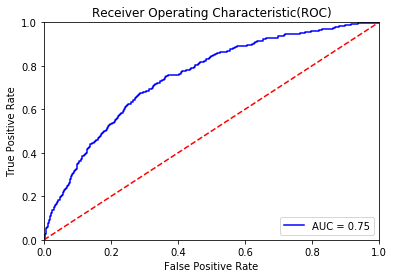

In [32]:
# Plotting ROC curve

plt.title('Receiver Operating Characteristic(ROC)')
plt.plot(falsePositiveRate, truePositiverate, 'b', label = 'AUC = %0.2f' % roc_score)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

** The ROC curve is a nice way to observe how any predictive model can distinguish between true positives and negatives - it does it by plotting TPR with FPR. The ROC-curve gives you a set of thresholds out of which the optimum threshold can be chosen **

In [33]:
optimal_idx = np.argmax(truePositiverate-falsePositiveRate)
optimal_threshold = threshold[optimal_idx]
print(optimal_threshold)

0.43203143178694625


In [34]:
## updating the classes with the optimal threhsold
predicted_classes = np.where(predictions>optimal_threshold, 1, 0)

In [35]:
accuracy_score(y_test, predicted_classes)

0.659

In [36]:
confusion_mat = confusion_matrix(y_test,predicted_classes)
confusion_df  = pd.DataFrame(confusion_mat,index=['Actual 0', 'Actual 1'],columns=['Predicted 0','Predicted 1'])
confusion_df

,Predicted 0,Predicted 1
Actual 0,984,575
Actual 1,107,334


** The number of actual '1's being classified as '1' has gone up from 292 to 334 **

In [37]:
print(classification_report(y_test,predicted_classes))

              precision    recall  f1-score   support

           0       0.90      0.63      0.74      1559
           1       0.37      0.76      0.49       441

   micro avg       0.66      0.66      0.66      2000
   macro avg       0.63      0.69      0.62      2000
weighted avg       0.78      0.66      0.69      2000



** Although Accuracy has dropped by a very small % (~ 0.001), it isn't the be-all, end-all of model metrics, especially with an imbalanced dataset - hence the importance of other metrics such as Recall, Precision and F1-score. Recall has improved from from 66% to 76% - with the price of Precision dropping. There will always be a trade-off between these two metrics and that depends on the business problem at hand **

** we use the final set of features to run the model using sklearn's LogisticRegression model and save the model **

### Logistic Regression

In [38]:
#Instantiating model and fitting the train variables
lrclassifier = LogisticRegression(max_iter=2000)
lrclassifier.fit(x_train_new,y_train_new)

C:\Users\VK\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=2000, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

**max_iter parameter refers to the maximum number of iterations taken for the solvers (algorithms) to converge**

In [39]:
#Predicting target values for x_test
lrpredict = lrclassifier.predict(x_test)

In [40]:
lrpredict[1:5]

array([1, 0, 1, 1], dtype=int64)

In [41]:
#Saving the best model as pickle file
filename = 'Final_Model.sav'
pickle.dump(lrclassifier, open(filename, 'wb'))

** end of notebook **